# **DS331 Lab 5: CRISP-DM Phase4, Modeling (Frequent Pattern Mining)🔍**



### 📥 Download AI in HealthCare Dataset  
[<button style="background-color:#008CBA; color:white; padding:10px 15px; border:none; border-radius:5px;">Click Here to Download</button>](https://drive.google.com/drive/folders/18UHGmcat5yFGkQPmzgwkntlCnMz89UCw?usp=drive_link)

In [68]:
# ----------------------------
# Import Libraries and Dataset
# ----------------------------

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display


df = pd.read_csv("AI_dataset_cleaned.csv")
print(df.head())

   Patient_ID   Age  Gender  Blood_Pressure  Heart_Rate  Temperature  \
0           1  62.0  Female      102.349134        79.0    98.912361   
1           2  65.0    Male      137.760933        72.0    98.912508   
2           3  54.0    Male       97.618564        57.0    99.189728   
3           4  54.0    Male      121.743752        67.0    96.033487   
4           5  85.0    Male      129.530450        64.0    99.077675   

       Diagnosis    Medication Insurance_Type  Doctor_Name  \
0   Hypertension       Statins      Uninsured    Dr. Brown   
1   Hypertension       Insulin      Uninsured     Dr. Wang   
2      Influenza  Chemotherapy        Private  Dr. Johnson   
3  Heart Disease  Chemotherapy        Private    Dr. Smith   
4  Heart Disease       Insulin        Private      Dr. Lee   

         Hospital_Name  Lab_Test_Results X-ray_Results         Surgery_Type  \
0  Children's Hospital        114.906151      Abnormal         Appendectomy   
1    Healthcare Clinic         88.55

In [70]:
# -------------------------------------------------------
# Install necessary packages
# -------------------------------------------------------
!pip install mlxtend

## **1. Preparing Data for Pattern Minings**


In [72]:
# ------------------------------------------------------- 
# Step 1: Select attributes relevant for pattern mining 
# -------------------------------------------------------

# Columns to include for pattern mining (as specified)
features = [ 'Age', 'Gender', 'Blood_Pressure', 'Heart_Rate', 'Temperature',
    'Medication', 'Insurance_Type', 'X-ray_Results',
    'Surgery_Type', 'Family_History', 'AI_Diagnosis_Confidence'
]

# Create a new dataframe with selected attributes 
df_mining = df[features].copy()

# Preview 
df_mining.dtypes

Age                        float64
Gender                      object
Blood_Pressure             float64
Heart_Rate                 float64
Temperature                float64
Medication                  object
Insurance_Type              object
X-ray_Results               object
Surgery_Type                object
Family_History              object
AI_Diagnosis_Confidence    float64
dtype: object

In [73]:
columns_of_interest = ['Age', 'Blood_Pressure', 'Heart_Rate', 'Temperature', 'AI_Diagnosis_Confidence']

min_max_values = df_mining[columns_of_interest].agg(['min', 'max'])

display(min_max_values)

,Age,Blood_Pressure,Heart_Rate,Temperature,AI_Diagnosis_Confidence
min,18.0,70.872459,43.0,22.500000,0.700309
max,89.0,166.308440,108.0,101.920893,0.989988


In [74]:
# -------------------------------------------------------
# Step 2: Convert all relevant attributes to Categorical.
# -------------------------------------------------------

# Discretize 'Age' column into age groups
#   (0–30]     → Young
#   (30–55]    → Adult
#   (55–75]    → Senior
#   (75–100]   → Elderly
df_mining['Age'] = pd.cut(
    df_mining['Age'],
    bins=[0, 30, 55, 75, 100],
    labels=['Young', 'Adult', 'Senior', 'Elderly']
)

# Discretize 'Blood_Pressure' into levels
#   (0–90]     → Low
#   (90–120]   → Normal
#   (120–140]  → Pre-High
#   (140–∞)    → High
df_mining['Blood_Pressure'] = pd.cut(
    df_mining['Blood_Pressure'],
    bins=[0, 90, 120, 140, float('inf')],
    labels=['Low', 'Normal', 'Pre-High', 'High']
)

# Discretize 'Heart_Rate' into heart rate ranges
#   (0–40]     → Critical
#   (40–60]     → Low
#   (60–100]   → Normal
#   (100–∞)    → High
df_mining['Heart_Rate'] = pd.cut(
    df_mining['Heart_Rate'],
    bins=[0, 40, 60, 100, float('inf')],
    labels=['Critical', 'Low', 'Normal', 'High']
)

# Discretize 'Temperature' into body temp levels
#   (0–97]     → Low
#   (97–99]    → Normal
#   (99–101]   → Slightly High
#   (101–∞)    → Fever
df_mining['Temperature'] = pd.cut(
    df_mining['Temperature'],
    bins=[0, 97, 99, 101, float('inf')], 
    labels=['Low', 'Normal', 'Slightly High', 'Fever']
)

# Discretize 'AI_Diagnosis_Confidence' into confidence levels
#   (0–0.75]   → Low
#   (0.75–0.85]→ Medium
#   (0.85–0.95]→ High
#   (0.95–1.0] → Very High
df_mining['AI_Diagnosis_Confidence'] = pd.cut(
    df_mining['AI_Diagnosis_Confidence'],
    bins=[0, 0.75, 0.85, 0.95, 1.0],
    labels=['Low', 'Medium', 'High', 'Very High']
)

# Convert all object-type columns (e.g., Gender, Medication) to categorical type
for col in df_mining.select_dtypes(include='object').columns:
    df_mining[col] = df_mining[col].astype('category')

# Optional: Preview to confirm all columns are now categorical
df_mining.dtypes

Age                        category
Gender                     category
Blood_Pressure             category
Heart_Rate                 category
Temperature                category
Medication                 category
Insurance_Type             category
X-ray_Results              category
Surgery_Type               category
Family_History             category
AI_Diagnosis_Confidence    category
dtype: object

In [75]:
# -------------------------------------------------------
# Step 3: Transform the dataset into a transaction format
# -------------------------------------------------------

# Create a list of transactions in the format: "column = value"
# This makes each item more interpretable (e.g., "Age = Adult")
# Each transaction is a list of such "column = value" strings
transactions = [
    [f"{col} = {val}" for col, val in zip(df_mining.columns, row)]
    for row in df_mining.values.tolist()
]

# Preview the first 3 transactions to verify formatting
for t in transactions[:3]:
    display(t)
    print("\n")

['Age = Senior',
 'Gender = Female',
 'Blood_Pressure = Normal',
 'Heart_Rate = Normal',
 'Temperature = Normal',
 'Medication = Statins',
 'Insurance_Type = Uninsured',
 'X-ray_Results = Abnormal',
 'Surgery_Type = Appendectomy',
 'Family_History = Heart Disease',
 'AI_Diagnosis_Confidence = High']

['Age = Senior',
 'Gender = Male',
 'Blood_Pressure = Pre-High',
 'Heart_Rate = Normal',
 'Temperature = Normal',
 'Medication = Insulin',
 'Insurance_Type = Uninsured',
 'X-ray_Results = Normal',
 'Surgery_Type = Knee Replacement',
 'Family_History = Diabetes',
 'AI_Diagnosis_Confidence = Medium']

['Age = Adult',
 'Gender = Male',
 'Blood_Pressure = Normal',
 'Heart_Rate = Low',
 'Temperature = Slightly High',
 'Medication = Chemotherapy',
 'Insurance_Type = Private',
 'X-ray_Results = Normal',
 'Surgery_Type = Gallbladder Removal',
 'Family_History = Hypertension',
 'AI_Diagnosis_Confidence = Medium']

In [76]:
# -------------------------------------------------------
# Step 4: One-Hot Encode the transactions
# -------------------------------------------------------

# Import TransactionEncoder (used to convert transaction lists into a one-hot encoded format for pattern mining)
from mlxtend.preprocessing import TransactionEncoder

# Initialize the TransactionEncoder from mlxtend
te = TransactionEncoder()

# Fit the encoder to the transaction data and transform it into a boolean array
te_ary = te.fit_transform(transactions)

# Convert the boolean array to a pandas DataFrame for compatibility with Apriori/FP-Growth
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Display the first few rows to verify the one-hot encoding structure
df_encoded.head()

,AI_Diagnosis_Confidence = High,AI_Diagnosis_Confidence = Low,AI_Diagnosis_Confidence = Medium,AI_Diagnosis_Confidence = Very High,Age = Adult,Age = Elderly,Age = Senior,Age = Young,Blood_Pressure = High,Blood_Pressure = Low,...,Surgery_Type = Appendectomy,Surgery_Type = Cataract Surgery,Surgery_Type = Gallbladder Removal,Surgery_Type = Knee Replacement,Temperature = Fever,Temperature = Low,Temperature = Normal,Temperature = Slightly High,X-ray_Results = Abnormal,X-ray_Results = Normal
0,True,False,False,False,False,False,True,False,False,False,...,True,False,False,False,False,False,True,False,True,False
1,False,False,True,False,False,False,True,False,False,False,...,False,False,False,True,False,False,True,False,False,True
2,False,False,True,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,True
3,False,False,True,False,True,False,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
4,False,False,True,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,True,True,False




# **✨ 2. Mining Frequent Patterns**

- Use algorithms like **Apriori** or **FP-Growth** to extract frequent itemsets from your one-hot encoded dataset.
 
- Make sure your categorical columns are converted properly using one-hot encoding! ✅
 
- Set a **min_support threshold** to filter patterns that appear in a significant number of records.

   Example:  `min_support = 0.01`→ appears in 1% of records.




In [78]:
# -------------------------------------------------------
# Step 5: Apply a frequent pattern mining algorithm
# -------------------------------------------------------

# Import algorithms to find frequent itemsets
from mlxtend.frequent_patterns import apriori, fpgrowth

# Set the minimum support threshold (e.g., 0.3 = 30%)
min_support = 0.3

# Option 1: Apply Apriori algorithm
frequent_itemsets_apriori = apriori(
    df_encoded,
    min_support=min_support,
    use_colnames=True
)

# Option 2: Apply FP-Growth algorithm
frequent_itemsets_fpgrowth = fpgrowth(
    df_encoded,
    min_support=min_support,
    use_colnames=True
)

In [79]:
# -------------------------------------------------------
# Step 6: Filter and inspect frequent itemsets.
# -------------------------------------------------------

# Filter 2-itemsets from Apriori output
apriori_2_itemsets = frequent_itemsets_apriori[
    frequent_itemsets_apriori['itemsets'].apply(lambda x: len(x) == 2)
].sort_values(by='support', ascending=False)

# Filter 2-itemsets from FP-Growth output
fpgrowth_2_itemsets = frequent_itemsets_fpgrowth[
    frequent_itemsets_fpgrowth['itemsets'].apply(lambda x: len(x) == 2)
].sort_values(by='support', ascending=False)

# Temporarily allow wider column display
pd.set_option('display.max_colwidth', None)

# Display top 5 from each
print(f"Total 2-itemsets from Apriori: {len(apriori_2_itemsets)}")
print("Top five 2-itemsets:")
display(apriori_2_itemsets.head(5))

print(f"\n\nTotal 2-itemsets from FP-Growth: {len(fpgrowth_2_itemsets)}")
print("Top five 2-itemsets:")
display(fpgrowth_2_itemsets.head(5))

Total 2-itemsets from Apriori: 12
Top five 2-itemsets:


,support,itemsets
20,0.559550,"(Temperature = Normal, Heart_Rate = Normal)"
14,0.535950,"(Heart_Rate = Normal, Blood_Pressure = Normal)"
17,0.475302,"(Heart_Rate = Normal, Gender = Female)"
21,0.470637,"(X-ray_Results = Abnormal, Heart_Rate = Normal)"
22,0.469265,"(Heart_Rate = Normal, X-ray_Results = Normal)"




Total 2-itemsets from FP-Growth: 12
Top five 2-itemsets:


,support,itemsets
11,0.559550,"(Temperature = Normal, Heart_Rate = Normal)"
12,0.535950,"(Heart_Rate = Normal, Blood_Pressure = Normal)"
15,0.475302,"(Heart_Rate = Normal, Gender = Female)"
16,0.470637,"(X-ray_Results = Abnormal, Heart_Rate = Normal)"
18,0.469265,"(Heart_Rate = Normal, X-ray_Results = Normal)"


## **3. Generating Association Rules**


In [81]:
# -------------------------------------------------------
# Step 7: Generate association rules from frequent itemsets
# -------------------------------------------------------
# Import library to generate association rules
from mlxtend.frequent_patterns import association_rules

# Choose frequent itemsets (using Apriori, as in example code)
frequent_itemsets = frequent_itemsets_apriori  # Alternatively: frequent_itemsets_fpgrowth

# Generate association rules using confidence as the evaluation metric
rules = association_rules(
    frequent_itemsets,          # Input: frequent itemsets from Step 5
    metric="confidence",        # Rule evaluation metric
    min_threshold=0.6           # Minimum confidence threshold (60%)
)

# Preview sample association rules with key columns
print("Total # of association rules: ", len(rules))
print("Association rules preview: ")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


Total # of association rules:  12
Association rules preview: 


,antecedents,consequents,support,confidence,lift
0,(AI_Diagnosis_Confidence = High),(Heart_Rate = Normal),0.319155,0.940939,1.001104
1,(AI_Diagnosis_Confidence = Medium),(Heart_Rate = Normal),0.328760,0.938871,0.998904
2,(Age = Adult),(Heart_Rate = Normal),0.415752,0.931734,0.991311
3,(Blood_Pressure = Normal),(Heart_Rate = Normal),0.535950,0.943478,1.003806
4,(Blood_Pressure = Pre-High),(Heart_Rate = Normal),0.307080,0.935619,0.995444
5,(Gender = Female),(Heart_Rate = Normal),0.475302,0.943355,1.003675
6,(Gender = Male),(Heart_Rate = Normal),0.464599,0.936394,0.996268
7,(Gender = Male),(Temperature = Normal),0.301317,0.607301,1.017006
8,(Temperature = Normal),(Heart_Rate = Normal),0.559550,0.937040,0.996956
9,(X-ray_Results = Abnormal),(Heart_Rate = Normal),0.470637,0.935115,0.994907


In [82]:
# -------------------------------------------------------
# Step 8: Filter and sort rules based on confidence and lift
# -------------------------------------------------------
# Filter rules to keep only strong and interesting ones
# Criteria: confidence > 0.7 and lift > 1
strong_rules = rules[
    (rules['confidence'] > 0.7) &
    (rules['lift'] > 1)
]

# Sort the filtered rules by descending lift
strong_rules = strong_rules.sort_values(by='lift', ascending=False)

# Preview sample strong rules with key columns
print("Total # of strong association rules: ", len(strong_rules))
print("Strong association rules preview: ")
display(strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

Total # of strong association rules:  4
Strong association rules preview: 


,antecedents,consequents,support,confidence,lift
10,(X-ray_Results = Normal),(Heart_Rate = Normal),0.469265,0.944751,1.005160
3,(Blood_Pressure = Normal),(Heart_Rate = Normal),0.535950,0.943478,1.003806
5,(Gender = Female),(Heart_Rate = Normal),0.475302,0.943355,1.003675
0,(AI_Diagnosis_Confidence = High),(Heart_Rate = Normal),0.319155,0.940939,1.001104


In [83]:
# -------------------------------------------------------
# Step 9: Filter rules based on a specific antecedent column
# -------------------------------------------------------
# Define the column of interest (e.g., 'Insurance_Type')
target_column = 'Blood_Pressure ='  

# Filter rules where the antecedent contains any item from the target column
rules_with_target = rules[
    rules['antecedents'].apply(lambda x: any(target_column in item for item in x))
].sort_values(by='lift', ascending=False)

# Preview sample rules with key columns
print("Total # of rules with Insurance_Type in antecedents: ", len(rules_with_target))
print("Rules preview: ")
display(rules_with_target[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

Total # of rules with Insurance_Type in antecedents:  3
Rules preview: 


,antecedents,consequents,support,confidence,lift
3,(Blood_Pressure = Normal),(Heart_Rate = Normal),0.535950,0.943478,1.003806
11,"(Blood_Pressure = Normal, Temperature = Normal)",(Heart_Rate = Normal),0.315313,0.937959,0.997934
4,(Blood_Pressure = Pre-High),(Heart_Rate = Normal),0.307080,0.935619,0.995444


## **4. Visualizing Association Rules as a Network Graph**

In [85]:
# -------------------------------------------------------
# Install necessary packages
# -------------------------------------------------------
!pip install NetworkX

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_2524\155721414.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()      # Auto-adjust layout for clarity


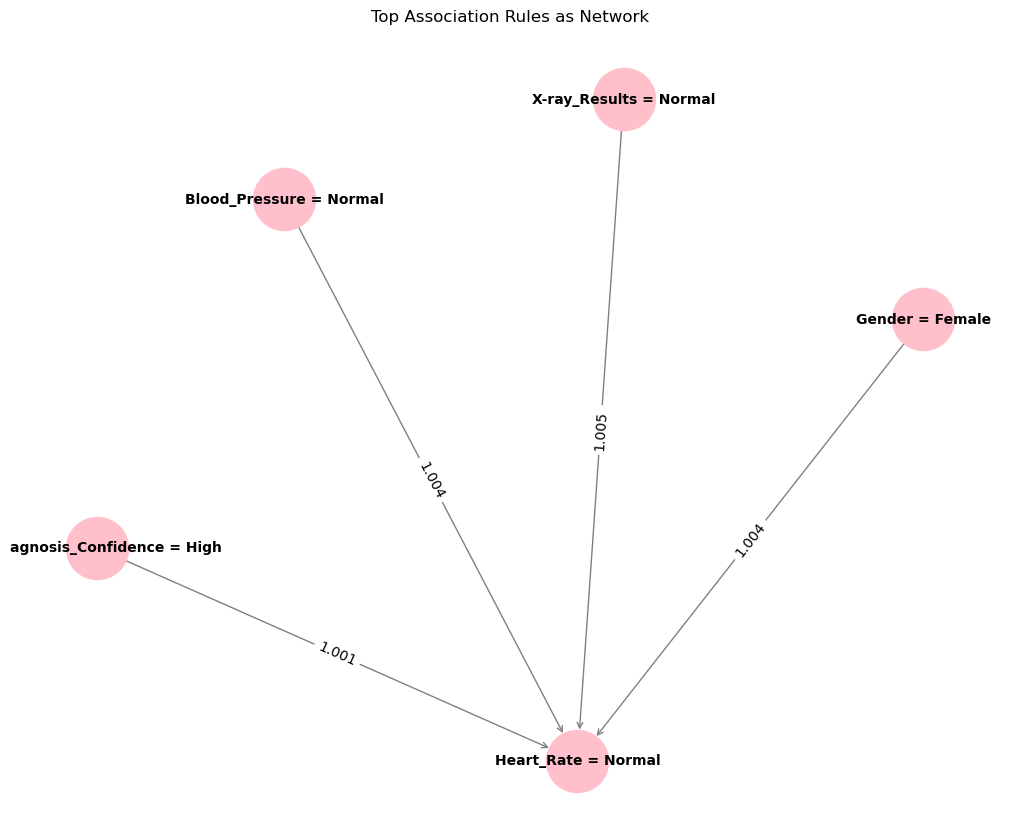

In [86]:
# -------------------------------------------------------
# Step 10: Visualizing Association Rules as a Network Graph
# -------------------------------------------------------

# Create a directed graph
G = nx.DiGraph()

# Check if strong_rules is empty
if len(strong_rules) == 0:
    print("No strong rules available for visualization.")
else:
    # Add nodes and edges (top 10 strong rules, limited to available 4)
    for _, row in strong_rules.head(5).iterrows():
        for ant in row['antecedents']:
            for con in row['consequents']:
                G.add_edge(ant, con, weight=row['lift'])

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=24)  # Used spring layout with fixed arrangement

# Draw the nodes and edges
nx.draw(
    G,              # The graph object
    pos,            # Node positions
    with_labels=True,            # Show labels on nodes
    node_color='#FFC0CB',      # Node fill color
    node_size=2000,              # Size of each node
    font_size=10,                # Text label size
    font_weight='bold',          # Make labels bold
    arrows=True,                 # Show arrowheads
    arrowstyle='->',             # Arrow type
    edge_color='gray'            # Edge line color
)

# Draw the edge labels (lift values) on the graph
edge_labels = {
    (u, v): f"{d['weight']:.3f}"  # Format lift value to 3 decimal places (e.g., '1.005')
    for u, v, d in G.edges(data=True)  # Iterate over all edges with their data
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Finalize and display the plot
plt.title("Top Association Rules as Network")
plt.axis('off')         # Remove axis ticks and border
plt.tight_layout()      # Auto-adjust layout for clarity
plt.show()

## **Documenting Findings from Pattern Mining🔍**

This analysis applies the **CRISP-DM** methodology, specifically Phase 4: Modeling, using frequent pattern mining techniques on a cleaned medical dataset. The data was transformed into a suitable **transaction format**. The main steps include:


#### **Data Preparation for Pattern Mining ⚙**
- Selected important features such as **Age**, **Blood Pressure**, **Heart Rate**, **Surgery Type**, and **AI Diagnosis Confidence**.
- Numerical values were converted into **categorical ranges** (e.g., Age → Young, Adult, Senior, Elderly).
- Converted the dataset into **transactional format**: "column = value".

#### **Applying Pattern Mining Algorithms 🧠**
- Used **Apriori** and **FP-Growth** algorithms with min_support = 0.3.
- Both algorithms yielded **12 frequent 2-itemsets** with similar results.

#### **Key Frequent Patterns Identified ⭐**
- **Most frequent pattern**:
  - (Heart_Rate = Normal, Temperature = Normal) with **support = 55.9%**.
- Other common patterns link **Normal Heart Rate** with:
  - **Normal Blood Pressure**
  - **Female Gender**
  - **X-ray Results**

#### **Generating Association Rules ➕➖**
- Generated **12 association rules** using Apriori.
- Evaluated rules using: **support**, **confidence**, and **lift**.
- Top rules:
  - (X-ray_Results = Normal) → (Heart_Rate = Normal)  
    - **Confidence: 94.4%**, **Lift: 1.005**
  - (Blood_Pressure = Normal) → (Heart_Rate = Normal)  
    - **Confidence: 94.3%**, **Lift: 1.003**

#### **Filtering Strong Rules ✅**
- Filtered using:
  - confidence > 0.7 and lift > 1
- Found **4 strong rules**.
- These indicate that **normal medical indicators (like normal X-ray or blood pressure)** are strongly associated with **normal heart rate**.

#### **Visualizing Association Rules as a Network Graph 🌐**
- Created a **directed network graph** of the top association rules.
- This visualization helps in understanding relationships between medical variables clearly.

### **Final Conclusion 📝**

Through **frequent pattern mining** of medical data, important factors were identified that are associated with a **normal heart rate**. The discovered rules showed **high reliability** (confidence > 94%), supporting their use in **medical decision-making**, especially when combined with AI diagnostics and clinical observations.